In [1]:
import pandas as pd
import numpy as np
import string 
import re
import statistics
from nltk.corpus import stopwords
import seaborn as sns
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import os 
import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.models import Model
from keras.layers import *
from keras.layers import Embedding
from utils import *

[nltk_data] Downloading package stopwords to /Users/iulia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/iulia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/iulia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/Applications/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

In [3]:
# print(os.listdir("../input"))

['news-headlines-dataset-for-sarcasm-detection', 'glove-6b-50d']


In [2]:
data = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)

In [3]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
data.shape

(26709, 3)

In [5]:
# are all sarcastic headlines from Onion, and no-sarcastic headlines are from Huffington post 
def get_source(row):
    if 'theonion' in row:
        return 'Onion'
    else:
        return 'HP'
data['source'] = data['article_link'].apply(get_source)    

In [6]:
data.groupby(['source','is_sarcastic']).count()

article_link  headline
source is_sarcastic                        
HP     0                    14984     14984
Onion  0                        1         1
       1                    11724     11724

In [7]:
pd.set_option('display.max_colwidth', -1)
data[(data['source']=='Onion')&(data['is_sarcastic']==0)]
# this looks like an incorrect data point, as after manual inspection this article is obviously sarcastic

,article_link,headline,is_sarcastic,source
19948,https://www.huffingtonpost.comhttp://www.theonion.com/blogpost/do-you-know-why-im-pulling-you-over-being-wildly-a-50916,"do you know why i'm pulling you over, being wildly aggressive, and charging you with assault today, sir?",0,Onion


In [8]:
# correct this mistake
data.at[19948,'is_sarcastic']=1

### Basic Visualizations

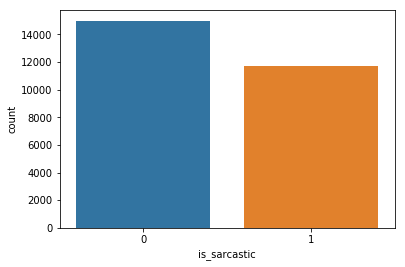

In [9]:
#Let's draw class distribution
sns.countplot(x = 'is_sarcastic', data = data)

We want to draw word clouds for both negative and positive classes, to make such visualization more clear we will do some preprocessing first (remove stopwords, punctuation and extract lemmas from words)

In [10]:
# remove punctuation
data['headline']=data['headline'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
# remove stopwords
data['headline'] = data['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))

# lematization
# we will use spaCy library for text lemmatization because unlike nltk it determines the pos autamatically and 
# return the correct lemma, while nltk needs pos to be specified explicitely for each word
spacy_model=spacy.load('en')
data['headline'] = data['headline'].apply(lambda x: " ".join([token.lemma_ for token in spacy_model(x)]))

In [11]:
# prepare text for word clouds
sarcastic_txt = " ".join(headline for headline in data[data.is_sarcastic==1]['headline'])
non_sarcastic_txt = " ".join(headline for headline in data[data.is_sarcastic==0]['headline'])

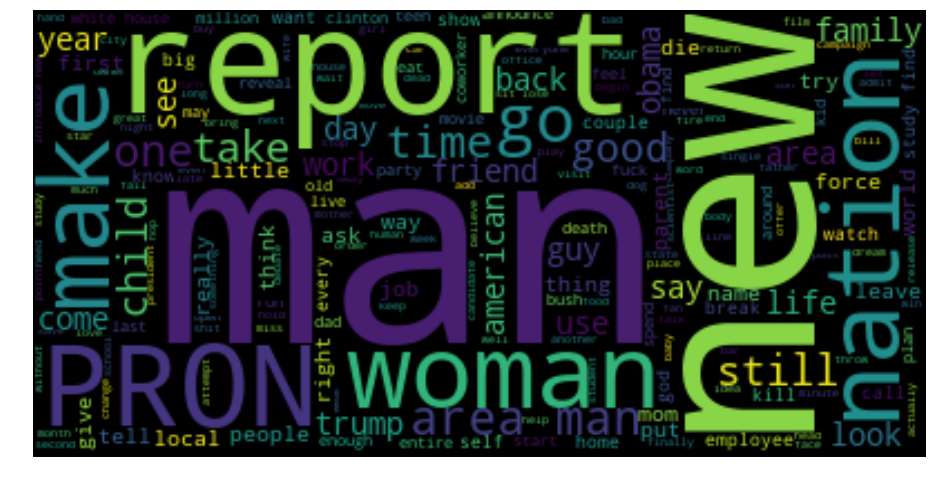

In [12]:
build_word_cloud(sarcastic_txt)

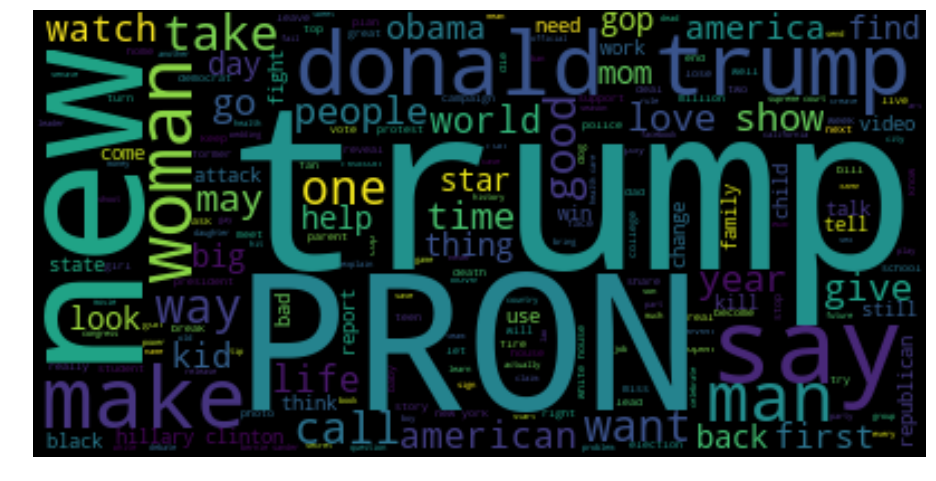

In [13]:
build_word_cloud(non_sarcastic_txt)

We will do some basic feature engineering to create some NLP-based features and visualize them 

## Engineering Text Based features

In [14]:
# number of words
data['words_num'] = data['headline'].apply(lambda x: len(x.split()))
data = data[data.words_num!=0]
# number of characters
data['chars_num'] = data['headline'].apply(lambda x: len(x.replace(" ","")))

# number of special characters
special = string.punctuation
data['special_chars_num'] = data['headline'].apply(lambda x: len([char for char in x if char in special]))

# average word length
data['word_len_avg'] = data['headline'].apply(lambda x: statistics.mean([len(word) for word in x.split()]))

# number of stopwords
sw=stopwords.words(['english'])
data['stopwords_num'] = data['headline'].apply(lambda x: len([word for word in x.split() if word in sw]))

# stopwords/ total words ratio
data['sw_ratio'] = data['stopwords_num']/data['words_num']

In [15]:
data.groupby('is_sarcastic')[['words_num', 'chars_num', 'special_chars_num', 'stopwords_num', 'sw_ratio']].agg(['min', 'max', 'mean'])

words_num               chars_num                  \
                   min max      mean       min  max       mean   
is_sarcastic                                                     
0             1         20  6.944804  3         130  39.134286   
1             1         37  7.505501  3         207  43.275309   

             special_chars_num               stopwords_num                \
                           min max      mean           min max      mean   
is_sarcastic                                                               
0             0                 6   0.098512  0             5   0.147834   
1             0                 4   0.079829  0             5   0.100554   

             sw_ratio                      
                  min       max      mean  
is_sarcastic                               
0             0.0      0.666667  0.019090  
1             0.0      0.500000  0.011063

In [16]:
# POS analysis
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']}

def pos_check(tokens, pos_flag):    
    pos = nltk.pos_tag(tokens)
    counter=0
    for pair in pos:
        if pair[1] in pos_family[pos_flag]:
            counter+=1
    return counter

data['tokens'] = data['headline'].apply(lambda x: nltk.word_tokenize(x))
data['noun_ratio'] = data['tokens'].apply(lambda x: pos_check(x, 'noun'))/data['words_num']
data['pron_ratio'] = data['tokens'].apply(lambda x: pos_check(x, 'pron'))/data['words_num']
data['verb_ratio'] = data['tokens'].apply(lambda x: pos_check(x, 'verb'))/data['words_num']
data['adj_ratio'] = data['tokens'].apply(lambda x: pos_check(x, 'adj'))/data['words_num']
data['adv_ratio'] = data['tokens'].apply(lambda x: pos_check(x, 'adv'))/data['words_num']

In [17]:
data.head()

,article_link,headline,is_sarcastic,source,words_num,chars_num,special_chars_num,word_len_avg,stopwords_num,sw_ratio,tokens,noun_ratio,pron_ratio,verb_ratio,adj_ratio,adv_ratio
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sue secret black code minority shopper,0,HP,10,56,0,5.600000,0,0.0,"[former, versace, store, clerk, sue, secret, black, code, minority, shopper]",0.700000,0.0,0.000,0.300000,0.000
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,roseanne revival catch thorny political mood better worse,0,HP,8,50,0,6.250000,0,0.0,"[roseanne, revival, catch, thorny, political, mood, better, worse]",0.500000,0.0,0.125,0.250000,0.125
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom start fear son web series close thing grandchild,1,Onion,9,44,0,4.888889,0,0.0,"[mom, start, fear, son, web, series, close, thing, grandchild]",0.777778,0.0,0.000,0.222222,0.000
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,boehner want wife listen come alternative debtreduction idea,1,Onion,8,53,0,6.625000,0,0.0,"[boehner, want, wife, listen, come, alternative, debtreduction, idea]",0.500000,0.0,0.125,0.250000,0.000
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,jk rowling wish snape happy birthday magical way,0,HP,8,41,0,5.125000,0,0.0,"[jk, rowling, wish, snape, happy, birthday, magical, way]",0.500000,0.0,0.125,0.375000,0.000


## CNN with pre-trained Word Embeddings

In [46]:
import utils
import importlib
importlib.reload(utils)
padded_docs, embedding_matrix = construct_embedding_matrix(data, 'headline')

len_max 37


In [24]:
# split our padded sentences on train and test
x_train, x_test, y_train, y_test = train_test_split(padded_docs, data['is_sarcastic'], test_size = 0.2,random_state=42)

In [25]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [26]:
inputs_text = Input(shape=(len_max,))
#inputs_nlp = Input(shape=(10,))
# first we need to create our embeddings layer
#embedding_layer = Embedding(vocab_size, 32, input_length= len_max)(inputs)
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=len_max, trainable = False)(inputs_text)
conv_1 = Conv1D(filters=64, kernel_size=1, strides=1, padding="valid", activation="relu")(embedding_layer)
conv_2 = Conv1D(filters=64, kernel_size=2,strides=1, padding="valid", activation="relu")(embedding_layer)
conv_3 = Conv1D(filters=64, kernel_size=3, strides=1, padding="valid", activation="relu")(embedding_layer)

maxpool_1 = MaxPooling1D(2)(conv_1)
dropout_1 = Dropout(0.4)(maxpool_1)

maxpool_2 = MaxPooling1D(2)(conv_2)
dropout_2 = Dropout(0.4)(maxpool_2)

maxpool_3 = MaxPooling1D(2)(conv_3)
dropout_3 = Dropout(0.4)(maxpool_3)

text_features = Concatenate(axis=1)([dropout_1, dropout_2, dropout_3])

flattened = Flatten()(text_features)
#all_features = Concatenate(axis=1)([flattened, inputs_nlp])

fc2 = Dense(units=256, activation='relu')(flattened)
dropout_4=Dropout(0.3)(fc2)
output_layer = Dense(units=1, activation="sigmoid")(dropout_4)
model = Model(inputs=inputs_text, outputs=output_layer)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 37)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 37, 50)       1122250     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 37, 64)       3264        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 36, 64)       6464        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [28]:
from keras.optimizers import RMSprop, Adam, SGD
optimizer = RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, 
              loss= f1_loss, #'binary_crossentropy', 
              metrics=['acc', f1])

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5',
                                verbose=1,
                                save_best_only=True,
                                monitor='val_f1', mode='max')

In [30]:
early_stop = EarlyStopping(monitor='val_f1', mode='max', verbose=1, 
                          patience=100)


In [31]:
history = model.fit(x_train, y_train, 
         batch_size=1000, 
         epochs=2000,
         validation_split=0.2,
         callbacks=[checkpointer, early_stop],
         verbose=2, shuffle=True
                   )

Instructions for updating:
Use tf.cast instead.
Train on 17092 samples, validate on 4274 samples
Epoch 1/2000
 - 1s - loss: 0.4304 - acc: 0.4453 - f1: 0.5847 - val_loss: 0.4036 - val_acc: 0.4319 - val_f1: 0.6032

Epoch 00001: val_f1 improved from -inf to 0.60323, saving model to model.weights.best.hdf5
Epoch 2/2000
 - 0s - loss: 0.3959 - acc: 0.4372 - f1: 0.6083 - val_loss: 0.3985 - val_acc: 0.4319 - val_f1: 0.6032

Epoch 00002: val_f1 did not improve from 0.60323
Epoch 3/2000
 - 0s - loss: 0.3929 - acc: 0.4372 - f1: 0.6082 - val_loss: 0.3972 - val_acc: 0.4319 - val_f1: 0.6032

Epoch 00003: val_f1 did not improve from 0.60323
Epoch 4/2000
 - 0s - loss: 0.3919 - acc: 0.4372 - f1: 0.6082 - val_loss: 0.3968 - val_acc: 0.4319 - val_f1: 0.6032

Epoch 00004: val_f1 did not improve from 0.60323
Epoch 5/2000
 - 0s - loss: 0.3915 - acc: 0.4372 - f1: 0.6083 - val_loss: 0.3966 - val_acc: 0.4319 - val_f1: 0.6032

Epoch 00005: val_f1 did not improve from 0.60323
Epoch 6/2000
 - 0s - loss: 0.3912 - 

 - 0s - loss: 0.3302 - acc: 0.6514 - f1: 0.6793 - val_loss: 0.3316 - val_acc: 0.6554 - val_f1: 0.6759

Epoch 00041: val_f1 improved from 0.67478 to 0.67587, saving model to model.weights.best.hdf5
Epoch 42/2000
 - 0s - loss: 0.3312 - acc: 0.6476 - f1: 0.6775 - val_loss: 0.3297 - val_acc: 0.6572 - val_f1: 0.6766

Epoch 00042: val_f1 improved from 0.67587 to 0.67665, saving model to model.weights.best.hdf5
Epoch 43/2000
 - 0s - loss: 0.3292 - acc: 0.6528 - f1: 0.6800 - val_loss: 0.3289 - val_acc: 0.6467 - val_f1: 0.6810

Epoch 00043: val_f1 improved from 0.67665 to 0.68101, saving model to model.weights.best.hdf5
Epoch 44/2000
 - 0s - loss: 0.3253 - acc: 0.6584 - f1: 0.6861 - val_loss: 0.3263 - val_acc: 0.6659 - val_f1: 0.6799

Epoch 00044: val_f1 did not improve from 0.68101
Epoch 45/2000
 - 0s - loss: 0.3272 - acc: 0.6562 - f1: 0.6813 - val_loss: 0.3246 - val_acc: 0.6703 - val_f1: 0.6821

Epoch 00045: val_f1 improved from 0.68101 to 0.68207, saving model to model.weights.best.hdf5
Epoc


Epoch 00085: val_f1 did not improve from 0.70520
Epoch 86/2000
 - 0s - loss: 0.2879 - acc: 0.7128 - f1: 0.7184 - val_loss: 0.3012 - val_acc: 0.7176 - val_f1: 0.7040

Epoch 00086: val_f1 did not improve from 0.70520
Epoch 87/2000
 - 0s - loss: 0.2918 - acc: 0.7153 - f1: 0.7154 - val_loss: 0.3020 - val_acc: 0.7209 - val_f1: 0.7045

Epoch 00087: val_f1 did not improve from 0.70520
Epoch 88/2000
 - 0s - loss: 0.2885 - acc: 0.7174 - f1: 0.7172 - val_loss: 0.2998 - val_acc: 0.6900 - val_f1: 0.7052

Epoch 00088: val_f1 improved from 0.70520 to 0.70524, saving model to model.weights.best.hdf5
Epoch 89/2000
 - 0s - loss: 0.2862 - acc: 0.7168 - f1: 0.7203 - val_loss: 0.2985 - val_acc: 0.6965 - val_f1: 0.7054

Epoch 00089: val_f1 improved from 0.70524 to 0.70541, saving model to model.weights.best.hdf5
Epoch 90/2000
 - 0s - loss: 0.2883 - acc: 0.7117 - f1: 0.7164 - val_loss: 0.2980 - val_acc: 0.7073 - val_f1: 0.7064

Epoch 00090: val_f1 improved from 0.70541 to 0.70637, saving model to model.wei


Epoch 00131: val_f1 improved from 0.71373 to 0.71507, saving model to model.weights.best.hdf5
Epoch 132/2000
 - 0s - loss: 0.2682 - acc: 0.7416 - f1: 0.7380 - val_loss: 0.2882 - val_acc: 0.7213 - val_f1: 0.7147

Epoch 00132: val_f1 did not improve from 0.71507
Epoch 133/2000
 - 0s - loss: 0.2682 - acc: 0.7407 - f1: 0.7361 - val_loss: 0.2879 - val_acc: 0.7227 - val_f1: 0.7150

Epoch 00133: val_f1 did not improve from 0.71507
Epoch 134/2000
 - 0s - loss: 0.2674 - acc: 0.7435 - f1: 0.7382 - val_loss: 0.2896 - val_acc: 0.7328 - val_f1: 0.7156

Epoch 00134: val_f1 improved from 0.71507 to 0.71560, saving model to model.weights.best.hdf5
Epoch 135/2000
 - 0s - loss: 0.2664 - acc: 0.7444 - f1: 0.7380 - val_loss: 0.2874 - val_acc: 0.7167 - val_f1: 0.7155

Epoch 00135: val_f1 did not improve from 0.71560
Epoch 136/2000
 - 0s - loss: 0.2669 - acc: 0.7425 - f1: 0.7390 - val_loss: 0.2871 - val_acc: 0.7220 - val_f1: 0.7169

Epoch 00136: val_f1 improved from 0.71560 to 0.71686, saving model to mode


Epoch 00177: val_f1 did not improve from 0.72455
Epoch 178/2000
 - 0s - loss: 0.2469 - acc: 0.7701 - f1: 0.7608 - val_loss: 0.2830 - val_acc: 0.7417 - val_f1: 0.7198

Epoch 00178: val_f1 did not improve from 0.72455
Epoch 179/2000
 - 0s - loss: 0.2501 - acc: 0.7664 - f1: 0.7553 - val_loss: 0.2820 - val_acc: 0.7433 - val_f1: 0.7246

Epoch 00179: val_f1 improved from 0.72455 to 0.72460, saving model to model.weights.best.hdf5
Epoch 180/2000
 - 0s - loss: 0.2502 - acc: 0.7633 - f1: 0.7549 - val_loss: 0.2810 - val_acc: 0.7169 - val_f1: 0.7190

Epoch 00180: val_f1 did not improve from 0.72460
Epoch 181/2000
 - 0s - loss: 0.2488 - acc: 0.7650 - f1: 0.7568 - val_loss: 0.2806 - val_acc: 0.7174 - val_f1: 0.7178

Epoch 00181: val_f1 did not improve from 0.72460
Epoch 182/2000
 - 0s - loss: 0.2506 - acc: 0.7623 - f1: 0.7542 - val_loss: 0.2813 - val_acc: 0.7426 - val_f1: 0.7252

Epoch 00182: val_f1 improved from 0.72460 to 0.72515, saving model to model.weights.best.hdf5
Epoch 183/2000
 - 0s - lo


Epoch 00224: val_f1 did not improve from 0.72860
Epoch 225/2000
 - 0s - loss: 0.2326 - acc: 0.7864 - f1: 0.7741 - val_loss: 0.2750 - val_acc: 0.7419 - val_f1: 0.7279

Epoch 00225: val_f1 did not improve from 0.72860
Epoch 226/2000
 - 0s - loss: 0.2374 - acc: 0.7795 - f1: 0.7684 - val_loss: 0.2745 - val_acc: 0.7380 - val_f1: 0.7275

Epoch 00226: val_f1 did not improve from 0.72860
Epoch 227/2000
 - 0s - loss: 0.2379 - acc: 0.7798 - f1: 0.7674 - val_loss: 0.2744 - val_acc: 0.7328 - val_f1: 0.7269

Epoch 00227: val_f1 did not improve from 0.72860
Epoch 228/2000
 - 0s - loss: 0.2362 - acc: 0.7808 - f1: 0.7703 - val_loss: 0.2750 - val_acc: 0.7452 - val_f1: 0.7290

Epoch 00228: val_f1 improved from 0.72860 to 0.72901, saving model to model.weights.best.hdf5
Epoch 229/2000
 - 0s - loss: 0.2385 - acc: 0.7773 - f1: 0.7660 - val_loss: 0.2749 - val_acc: 0.7440 - val_f1: 0.7284

Epoch 00229: val_f1 did not improve from 0.72901
Epoch 230/2000
 - 0s - loss: 0.2337 - acc: 0.7842 - f1: 0.7723 - val_l

 - 0s - loss: 0.2262 - acc: 0.7917 - f1: 0.7797 - val_loss: 0.2706 - val_acc: 0.7440 - val_f1: 0.7314

Epoch 00272: val_f1 did not improve from 0.73398
Epoch 273/2000
 - 0s - loss: 0.2240 - acc: 0.7920 - f1: 0.7810 - val_loss: 0.2721 - val_acc: 0.7494 - val_f1: 0.7316

Epoch 00273: val_f1 did not improve from 0.73398
Epoch 274/2000
 - 0s - loss: 0.2254 - acc: 0.7939 - f1: 0.7799 - val_loss: 0.2703 - val_acc: 0.7396 - val_f1: 0.7315

Epoch 00274: val_f1 did not improve from 0.73398
Epoch 275/2000
 - 0s - loss: 0.2262 - acc: 0.7889 - f1: 0.7782 - val_loss: 0.2706 - val_acc: 0.7466 - val_f1: 0.7332

Epoch 00275: val_f1 did not improve from 0.73398
Epoch 276/2000
 - 0s - loss: 0.2215 - acc: 0.7974 - f1: 0.7856 - val_loss: 0.2707 - val_acc: 0.7468 - val_f1: 0.7335

Epoch 00276: val_f1 did not improve from 0.73398
Epoch 277/2000
 - 0s - loss: 0.2243 - acc: 0.7922 - f1: 0.7803 - val_loss: 0.2705 - val_acc: 0.7389 - val_f1: 0.7298

Epoch 00277: val_f1 did not improve from 0.73398
Epoch 278/200


Epoch 00319: val_f1 did not improve from 0.73969
Epoch 320/2000
 - 0s - loss: 0.2120 - acc: 0.8052 - f1: 0.7923 - val_loss: 0.2676 - val_acc: 0.7567 - val_f1: 0.7352

Epoch 00320: val_f1 did not improve from 0.73969
Epoch 321/2000
 - 0s - loss: 0.2121 - acc: 0.8073 - f1: 0.7927 - val_loss: 0.2648 - val_acc: 0.7525 - val_f1: 0.7401

Epoch 00321: val_f1 improved from 0.73969 to 0.74007, saving model to model.weights.best.hdf5
Epoch 322/2000
 - 0s - loss: 0.2130 - acc: 0.8049 - f1: 0.7919 - val_loss: 0.2667 - val_acc: 0.7555 - val_f1: 0.7358

Epoch 00322: val_f1 did not improve from 0.74007
Epoch 323/2000
 - 0s - loss: 0.2157 - acc: 0.8028 - f1: 0.7877 - val_loss: 0.2643 - val_acc: 0.7506 - val_f1: 0.7391

Epoch 00323: val_f1 did not improve from 0.74007
Epoch 324/2000
 - 0s - loss: 0.2124 - acc: 0.8077 - f1: 0.7935 - val_loss: 0.2644 - val_acc: 0.7532 - val_f1: 0.7387

Epoch 00324: val_f1 did not improve from 0.74007
Epoch 325/2000
 - 0s - loss: 0.2131 - acc: 0.8069 - f1: 0.7934 - val_l


Epoch 00367: val_f1 did not improve from 0.74390
Epoch 368/2000
 - 0s - loss: 0.2068 - acc: 0.8118 - f1: 0.7970 - val_loss: 0.2607 - val_acc: 0.7515 - val_f1: 0.7429

Epoch 00368: val_f1 did not improve from 0.74390
Epoch 369/2000
 - 0s - loss: 0.2046 - acc: 0.8127 - f1: 0.8008 - val_loss: 0.2612 - val_acc: 0.7543 - val_f1: 0.7429

Epoch 00369: val_f1 did not improve from 0.74390
Epoch 370/2000
 - 0s - loss: 0.2011 - acc: 0.8167 - f1: 0.8034 - val_loss: 0.2621 - val_acc: 0.7541 - val_f1: 0.7402

Epoch 00370: val_f1 did not improve from 0.74390
Epoch 371/2000
 - 0s - loss: 0.2061 - acc: 0.8113 - f1: 0.7985 - val_loss: 0.2617 - val_acc: 0.7546 - val_f1: 0.7409

Epoch 00371: val_f1 did not improve from 0.74390
Epoch 372/2000
 - 0s - loss: 0.2050 - acc: 0.8154 - f1: 0.8011 - val_loss: 0.2632 - val_acc: 0.7560 - val_f1: 0.7372

Epoch 00372: val_f1 did not improve from 0.74390
Epoch 373/2000
 - 0s - loss: 0.2054 - acc: 0.8125 - f1: 0.7978 - val_loss: 0.2617 - val_acc: 0.7513 - val_f1: 0.740


Epoch 00416: val_f1 improved from 0.74460 to 0.74667, saving model to model.weights.best.hdf5
Epoch 417/2000
 - 0s - loss: 0.2011 - acc: 0.8173 - f1: 0.8039 - val_loss: 0.2578 - val_acc: 0.7564 - val_f1: 0.7440

Epoch 00417: val_f1 did not improve from 0.74667
Epoch 418/2000
 - 0s - loss: 0.1971 - acc: 0.8235 - f1: 0.8101 - val_loss: 0.2623 - val_acc: 0.7644 - val_f1: 0.7401

Epoch 00418: val_f1 did not improve from 0.74667
Epoch 419/2000
 - 0s - loss: 0.1982 - acc: 0.8217 - f1: 0.8063 - val_loss: 0.2590 - val_acc: 0.7588 - val_f1: 0.7427

Epoch 00419: val_f1 did not improve from 0.74667
Epoch 420/2000
 - 0s - loss: 0.1954 - acc: 0.8235 - f1: 0.8092 - val_loss: 0.2591 - val_acc: 0.7599 - val_f1: 0.7438

Epoch 00420: val_f1 did not improve from 0.74667
Epoch 421/2000
 - 0s - loss: 0.1945 - acc: 0.8248 - f1: 0.8104 - val_loss: 0.2594 - val_acc: 0.7611 - val_f1: 0.7441

Epoch 00421: val_f1 did not improve from 0.74667
Epoch 422/2000
 - 0s - loss: 0.1957 - acc: 0.8242 - f1: 0.8092 - val_l


Epoch 00464: val_f1 did not improve from 0.74802
Epoch 465/2000
 - 0s - loss: 0.1902 - acc: 0.8307 - f1: 0.8160 - val_loss: 0.2556 - val_acc: 0.7569 - val_f1: 0.7459

Epoch 00465: val_f1 did not improve from 0.74802
Epoch 466/2000
 - 0s - loss: 0.1889 - acc: 0.8302 - f1: 0.8162 - val_loss: 0.2590 - val_acc: 0.7672 - val_f1: 0.7451

Epoch 00466: val_f1 did not improve from 0.74802
Epoch 467/2000
 - 0s - loss: 0.1888 - acc: 0.8303 - f1: 0.8158 - val_loss: 0.2582 - val_acc: 0.7649 - val_f1: 0.7449

Epoch 00467: val_f1 did not improve from 0.74802
Epoch 468/2000
 - 0s - loss: 0.1889 - acc: 0.8316 - f1: 0.8173 - val_loss: 0.2589 - val_acc: 0.7651 - val_f1: 0.7444

Epoch 00468: val_f1 did not improve from 0.74802
Epoch 469/2000
 - 0s - loss: 0.1883 - acc: 0.8326 - f1: 0.8172 - val_loss: 0.2574 - val_acc: 0.7630 - val_f1: 0.7462

Epoch 00469: val_f1 did not improve from 0.74802
Epoch 470/2000
 - 0s - loss: 0.1860 - acc: 0.8342 - f1: 0.8200 - val_loss: 0.2566 - val_acc: 0.7616 - val_f1: 0.745


Epoch 00512: val_f1 did not improve from 0.74924
Epoch 513/2000
 - 0s - loss: 0.1808 - acc: 0.8385 - f1: 0.8241 - val_loss: 0.2555 - val_acc: 0.7691 - val_f1: 0.7487

Epoch 00513: val_f1 did not improve from 0.74924
Epoch 514/2000
 - 0s - loss: 0.1826 - acc: 0.8369 - f1: 0.8226 - val_loss: 0.2558 - val_acc: 0.7672 - val_f1: 0.7472

Epoch 00514: val_f1 did not improve from 0.74924
Epoch 515/2000
 - 0s - loss: 0.1788 - acc: 0.8422 - f1: 0.8275 - val_loss: 0.2590 - val_acc: 0.7723 - val_f1: 0.7449

Epoch 00515: val_f1 did not improve from 0.74924
Epoch 516/2000
 - 0s - loss: 0.1796 - acc: 0.8411 - f1: 0.8262 - val_loss: 0.2540 - val_acc: 0.7628 - val_f1: 0.7478

Epoch 00516: val_f1 did not improve from 0.74924
Epoch 517/2000
 - 0s - loss: 0.1830 - acc: 0.8381 - f1: 0.8235 - val_loss: 0.2536 - val_acc: 0.7609 - val_f1: 0.7472

Epoch 00517: val_f1 did not improve from 0.74924
Epoch 518/2000
 - 0s - loss: 0.1808 - acc: 0.8387 - f1: 0.8249 - val_loss: 0.2570 - val_acc: 0.7700 - val_f1: 0.745


Epoch 00560: val_f1 did not improve from 0.75180
Epoch 561/2000
 - 0s - loss: 0.1736 - acc: 0.8478 - f1: 0.8328 - val_loss: 0.2558 - val_acc: 0.7702 - val_f1: 0.7456

Epoch 00561: val_f1 did not improve from 0.75180
Epoch 562/2000
 - 0s - loss: 0.1748 - acc: 0.8458 - f1: 0.8309 - val_loss: 0.2519 - val_acc: 0.7651 - val_f1: 0.7513

Epoch 00562: val_f1 did not improve from 0.75180
Epoch 563/2000
 - 0s - loss: 0.1758 - acc: 0.8430 - f1: 0.8288 - val_loss: 0.2551 - val_acc: 0.7716 - val_f1: 0.7486

Epoch 00563: val_f1 did not improve from 0.75180
Epoch 564/2000
 - 0s - loss: 0.1716 - acc: 0.8489 - f1: 0.8336 - val_loss: 0.2529 - val_acc: 0.7700 - val_f1: 0.7511

Epoch 00564: val_f1 did not improve from 0.75180
Epoch 565/2000
 - 0s - loss: 0.1721 - acc: 0.8486 - f1: 0.8346 - val_loss: 0.2587 - val_acc: 0.7730 - val_f1: 0.7442

Epoch 00565: val_f1 did not improve from 0.75180
Epoch 566/2000
 - 0s - loss: 0.1731 - acc: 0.8500 - f1: 0.8345 - val_loss: 0.2514 - val_acc: 0.7656 - val_f1: 0.750

 - 0s - loss: 0.1711 - acc: 0.8479 - f1: 0.8338 - val_loss: 0.2558 - val_acc: 0.7728 - val_f1: 0.7469

Epoch 00609: val_f1 did not improve from 0.75510
Epoch 610/2000
 - 0s - loss: 0.1654 - acc: 0.8564 - f1: 0.8416 - val_loss: 0.2604 - val_acc: 0.7756 - val_f1: 0.7429

Epoch 00610: val_f1 did not improve from 0.75510
Epoch 611/2000
 - 0s - loss: 0.1707 - acc: 0.8498 - f1: 0.8340 - val_loss: 0.2507 - val_acc: 0.7733 - val_f1: 0.7547

Epoch 00611: val_f1 did not improve from 0.75510
Epoch 612/2000
 - 0s - loss: 0.1679 - acc: 0.8531 - f1: 0.8381 - val_loss: 0.2531 - val_acc: 0.7735 - val_f1: 0.7501

Epoch 00612: val_f1 did not improve from 0.75510
Epoch 613/2000
 - 0s - loss: 0.1660 - acc: 0.8534 - f1: 0.8397 - val_loss: 0.2519 - val_acc: 0.7754 - val_f1: 0.7528

Epoch 00613: val_f1 did not improve from 0.75510
Epoch 614/2000
 - 0s - loss: 0.1701 - acc: 0.8510 - f1: 0.8371 - val_loss: 0.2543 - val_acc: 0.7742 - val_f1: 0.7481

Epoch 00614: val_f1 did not improve from 0.75510
Epoch 615/200


Epoch 00657: val_f1 did not improve from 0.75923
Epoch 658/2000
 - 0s - loss: 0.1632 - acc: 0.8572 - f1: 0.8430 - val_loss: 0.2485 - val_acc: 0.7763 - val_f1: 0.7584

Epoch 00658: val_f1 did not improve from 0.75923
Epoch 659/2000
 - 0s - loss: 0.1592 - acc: 0.8601 - f1: 0.8464 - val_loss: 0.2494 - val_acc: 0.7761 - val_f1: 0.7564

Epoch 00659: val_f1 did not improve from 0.75923
Epoch 660/2000
 - 0s - loss: 0.1611 - acc: 0.8583 - f1: 0.8448 - val_loss: 0.2535 - val_acc: 0.7747 - val_f1: 0.7488

Epoch 00660: val_f1 did not improve from 0.75923
Epoch 661/2000
 - 0s - loss: 0.1598 - acc: 0.8621 - f1: 0.8473 - val_loss: 0.2545 - val_acc: 0.7742 - val_f1: 0.7459

Epoch 00661: val_f1 did not improve from 0.75923
Epoch 662/2000
 - 0s - loss: 0.1598 - acc: 0.8607 - f1: 0.8463 - val_loss: 0.2521 - val_acc: 0.7754 - val_f1: 0.7513

Epoch 00662: val_f1 did not improve from 0.75923
Epoch 663/2000
 - 0s - loss: 0.1593 - acc: 0.8614 - f1: 0.8466 - val_loss: 0.2566 - val_acc: 0.7759 - val_f1: 0.746

 - 0s - loss: 0.1570 - acc: 0.8632 - f1: 0.8487 - val_loss: 0.2525 - val_acc: 0.7737 - val_f1: 0.7483

Epoch 00706: val_f1 did not improve from 0.76259
Epoch 707/2000
 - 0s - loss: 0.1539 - acc: 0.8689 - f1: 0.8554 - val_loss: 0.2504 - val_acc: 0.7766 - val_f1: 0.7544

Epoch 00707: val_f1 did not improve from 0.76259
Epoch 708/2000
 - 0s - loss: 0.1557 - acc: 0.8656 - f1: 0.8516 - val_loss: 0.2499 - val_acc: 0.7745 - val_f1: 0.7545

Epoch 00708: val_f1 did not improve from 0.76259
Epoch 709/2000
 - 0s - loss: 0.1551 - acc: 0.8641 - f1: 0.8508 - val_loss: 0.2508 - val_acc: 0.7752 - val_f1: 0.7525

Epoch 00709: val_f1 did not improve from 0.76259
Epoch 710/2000
 - 0s - loss: 0.1538 - acc: 0.8661 - f1: 0.8522 - val_loss: 0.2494 - val_acc: 0.7756 - val_f1: 0.7543

Epoch 00710: val_f1 did not improve from 0.76259
Epoch 711/2000
 - 0s - loss: 0.1529 - acc: 0.8680 - f1: 0.8539 - val_loss: 0.2493 - val_acc: 0.7784 - val_f1: 0.7570

Epoch 00711: val_f1 did not improve from 0.76259
Epoch 712/200


Epoch 00755: val_f1 did not improve from 0.76259
Epoch 756/2000
 - 0s - loss: 0.1539 - acc: 0.8661 - f1: 0.8519 - val_loss: 0.2503 - val_acc: 0.7782 - val_f1: 0.7539

Epoch 00756: val_f1 did not improve from 0.76259
Epoch 757/2000
 - 0s - loss: 0.1502 - acc: 0.8695 - f1: 0.8557 - val_loss: 0.2523 - val_acc: 0.7768 - val_f1: 0.7489

Epoch 00757: val_f1 did not improve from 0.76259
Epoch 758/2000
 - 0s - loss: 0.1509 - acc: 0.8701 - f1: 0.8560 - val_loss: 0.2550 - val_acc: 0.7761 - val_f1: 0.7453

Epoch 00758: val_f1 did not improve from 0.76259
Epoch 759/2000
 - 0s - loss: 0.1482 - acc: 0.8727 - f1: 0.8590 - val_loss: 0.2512 - val_acc: 0.7777 - val_f1: 0.7522

Epoch 00759: val_f1 did not improve from 0.76259
Epoch 760/2000
 - 0s - loss: 0.1463 - acc: 0.8738 - f1: 0.8606 - val_loss: 0.2506 - val_acc: 0.7777 - val_f1: 0.7531

Epoch 00760: val_f1 did not improve from 0.76259
Epoch 761/2000
 - 0s - loss: 0.1472 - acc: 0.8733 - f1: 0.8586 - val_loss: 0.2534 - val_acc: 0.7763 - val_f1: 0.748

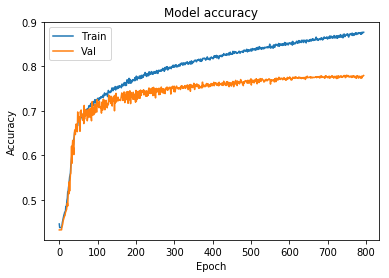

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

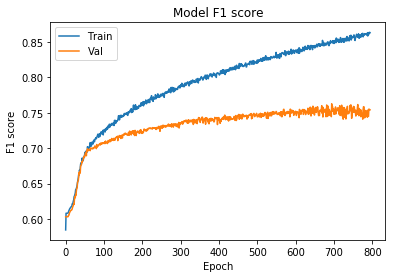

In [33]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [34]:
model.load_weights('model.weights.best.hdf5')

In [35]:
pred = model.predict(x_test)

In [36]:
pred_arr = []
for i in pred:
    pred_arr.append(round(i[0]))

from sklearn.metrics import confusion_matrix


In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_arr).ravel()


In [38]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score
tn, fp, fn, tp = confusion_matrix(y_test, pred_arr).ravel()
print('TN: %d, \nFP: %d, \nFN: %d, \nTP: %d' % (tn, fp,fn, tp))
print('Precision: ', round(precision_score(y_test, pred_arr),2))
print('Recall: ', round(recall_score(y_test, pred_arr),2))
print('F1 score: ', round(f1_score(y_test, pred_arr),2))
print('Accuracy score: ', round(accuracy_score(y_test, pred_arr),2))

TN: 2184, 
FP: 752, 
FN: 447, 
TP: 1959
Precision:  0.72
Recall:  0.81
F1 score:  0.77
Accuracy score:  0.78


In [39]:
#y_test_cat=to_categorical(y_test)
score = model.evaluate(x_test, y_test )

5342/5342 [==============================] - 0s 76us/step


In [40]:
score

[0.24462319290713844, 0.775552227719363, 0.7589320496912977]